In [4]:
import numpy as np
import torch as t
from torch import Tensor
import matplotlib.pyplot as plt
# now let us import jaxtyping
from jaxtyping import Float
import torch.optim as optim
from einops import rearrange, repeat

In [5]:
n_features = 100
n_neurons = 1
#make sigma a random matrix going from features to neurons
log_sigma = t.randn(n_features, n_neurons)
sigma = t.exp(log_sigma)

def create_data(sigma,datapoints):
    n_features = sigma.shape[0]
    n_neurons = sigma.shape[1]
    #create samples. Each sample is a random vector of size n_features
    inputs = t.exp(t.randn(datapoints, n_features))
    #compute the variations
    variations = t.mm(inputs, sigma)
    #compute teh data as normal destribution with mean 0 and variation variations
    noise = t.normal(mean=0, std=1, size=(datapoints, n_neurons))

    outputs = noise *t.sqrt( variations)

    return inputs,outputs

In [6]:
n_samples = 1000000
train_inputs, train_outputs = create_data(sigma,n_samples)
test_inputs, test_outputs = create_data(sigma,n_samples)

In [7]:
def NLL_k(inputs: Float[Tensor, "n_samples n_features"],outputs: Float[Tensor, "n_samples"],log_sigma: Float[Tensor, "n_features"]) -> Float:
    sigma = t.exp(log_sigma)
    predicted_variations = t.mm(inputs, sigma)
    predicted_stds = t.sqrt(predicted_variations)
    part_one = t.sum(t.log(predicted_stds))
    part_two = t.sum((outputs**2)/predicted_variations)/2

    return (part_one + part_two)/n_samples

In [8]:
nll_test_right_sigma = NLL_k(test_inputs,test_outputs,log_sigma)
nll_train_right_sigma = NLL_k(train_inputs,train_outputs,log_sigma)

In [9]:
first_guess_log_sigma = t.randn_like(log_sigma, requires_grad=True)
num_epochs = 2500
learning_rate = 0.01

optimizer = optim.Adam([first_guess_log_sigma], lr=learning_rate)
losses_train = []
losses_test = []
squared_distances = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    loss = NLL_k(train_inputs, train_outputs, first_guess_log_sigma)
    loss.backward()
    optimizer.step()

    with t.no_grad():
        test_loss = NLL_k(test_inputs, test_outputs, first_guess_log_sigma)
        losses_test.append(test_loss.item())
    
    losses_train.append(loss.item())
    squared_distance = t.sum((t.exp(first_guess_log_sigma) -sigma)**2).item()
    squared_distances.append(squared_distance)
    
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Squared Distance: {squared_distance:.4f}")

optimized_log_sigma = first_guess_log_sigma.detach()

Epoch [100/2500], Loss: 3.2519, Squared Distance: 244.7807
Epoch [200/2500], Loss: 3.2489, Squared Distance: 50.0052
Epoch [300/2500], Loss: 3.2484, Squared Distance: 15.2012
Epoch [400/2500], Loss: 3.2483, Squared Distance: 8.3366
Epoch [500/2500], Loss: 3.2482, Squared Distance: 5.5357
Epoch [600/2500], Loss: 3.2482, Squared Distance: 4.2451
Epoch [700/2500], Loss: 3.2482, Squared Distance: 3.6110
Epoch [800/2500], Loss: 3.2482, Squared Distance: 3.2889
Epoch [900/2500], Loss: 3.2482, Squared Distance: 3.1230
Epoch [1000/2500], Loss: 3.2482, Squared Distance: 3.0380
Epoch [1100/2500], Loss: 3.2482, Squared Distance: 2.9954
Epoch [1200/2500], Loss: 3.2482, Squared Distance: 2.9749
Epoch [1300/2500], Loss: 3.2482, Squared Distance: 2.9656
Epoch [1400/2500], Loss: 3.2482, Squared Distance: 2.9621
Epoch [1500/2500], Loss: 3.2482, Squared Distance: 2.9612
Epoch [1600/2500], Loss: 3.2482, Squared Distance: 2.9616
Epoch [1700/2500], Loss: 3.2482, Squared Distance: 2.9626
Epoch [1800/2500], 

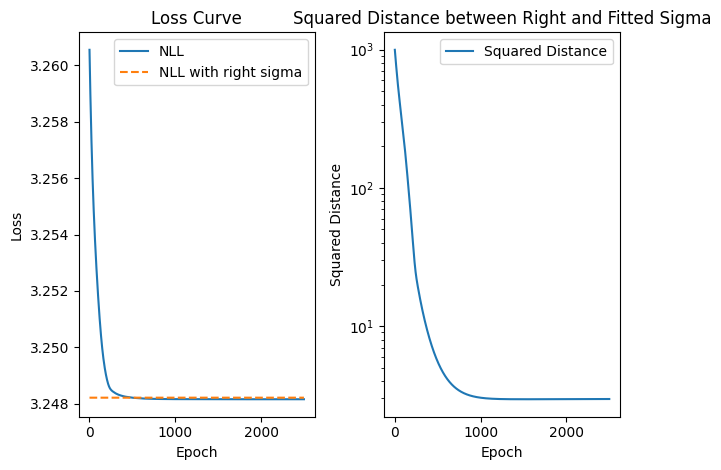

In [10]:
# Plot the lplt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(losses_train, label='NLL')
#plt.plot(losses_test, label='test Loss')
plt.plot([nll_train_right_sigma]*num_epochs, label='NLL with right sigma', linestyle='dashed')
#plt.plot([nll_test_right_sigma]*num_epochs, label='test Loss with right sigma', linestyle='dashed')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot the squared distance between right and fitted sigma
plt.subplot(1, 2, 2)
plt.plot(squared_distances, label='Squared Distance')
plt.xlabel('Epoch')
plt.ylabel('Squared Distance')
plt.title('Squared Distance between Right and Fitted Sigma')
plt.legend()
plt.yscale('log')

plt.tight_layout()
plt.show()

C:\Users\wusch\AppData\Local\Temp\ipykernel_40392\1883697950.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.scatter(sigma.flatten(), t.exp(t.tensor(optimized_log_sigma)).flatten())


Text(0, 0.5, 'Fitted Sigma Values')

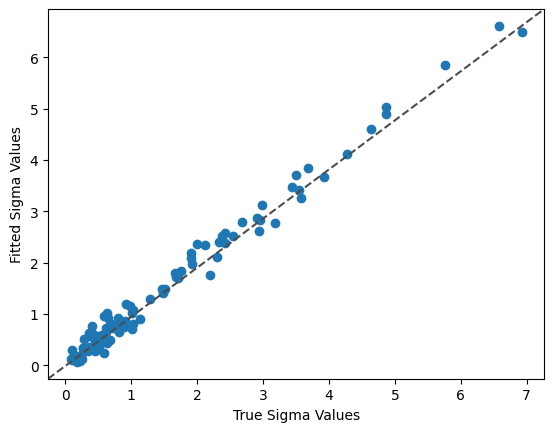

In [14]:
plt.scatter(sigma.flatten(), t.exp(t.tensor(optimized_log_sigma)).flatten())
#plot identity line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, ls="--", c=".3")
plt.xlabel('True Sigma Values')
plt.ylabel('Fitted Sigma Values')
